# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



# Имя на kaggle: Азат_Султангареев_465973724

### Установка зависимостей

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
import PIL
print(PIL.__version__)

10.0.1


In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [5]:
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [6]:
#!ls train

**Работал в Jupyter Notebook на своей видеокарте**

In [4]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Nov 20 12:45:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.17                 Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   28C    P8              15W / 225W |    498MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [1]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [9]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [12]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

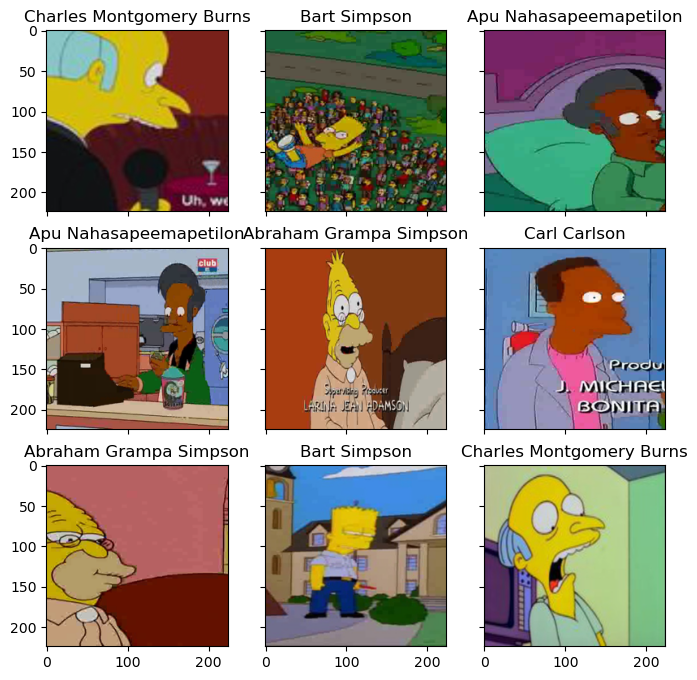

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [17]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(10 * 10 * 256, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU()
        )

        self.fc3 = nn.Linear(2048, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.fc3(x)
        return logits

In [14]:
class SimpleCnn2(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(10 * 10 * 256, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048)
        )

        self.fc3 = nn.Linear(2048, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.fc3(x)
        return logits

**Пробовал различные варианты, в итоге остановился на тех, что показаны выше**

### SimpleCnn по сути является облегченным аналогом структуры VGG

**Использовались стандартные батч-нормы, ReLu и MaxPool**

**В итоге данная сетка показала на kaggle 0.94155 на 20 эпохах**

### SimpleCnn2 отличается тем, что батч-норма использовалась после ReLu

**В итоге данная сетка показала на kaggle 0.95217 на 20 эпохах и 0.95324 на 40 эпохах (лучший показатель)**

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

**В функции train использовал AdamW вместо Adam**

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn2(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn2(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, s

Запустим обучение сети.

In [20]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

**Изменил размер батча на 128 (после многочисленных экспериментов)**

In [21]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=40, batch_size=128)

epoch:   0%|                                                                                    | 0/40 [00:00<?, ?it/s]

loss 1.8704276081786595


epoch:   2%|█▊                                                                       | 1/40 [03:41<2:23:42, 221.08s/it]


Epoch 001 train_loss: 1.8704     val_loss 1.3011 train_acc 0.5261 val_acc 0.6580
loss 1.0000635480545108


epoch:   5%|███▋                                                                     | 2/40 [05:33<1:39:33, 157.21s/it]


Epoch 002 train_loss: 1.0001     val_loss 0.9826 train_acc 0.7260 val_acc 0.7308
loss 0.5919507794094979


epoch:   8%|█████▍                                                                   | 3/40 [07:31<1:25:46, 139.11s/it]


Epoch 003 train_loss: 0.5920     val_loss 0.8599 train_acc 0.8308 val_acc 0.7805
loss 0.29855675877177096


epoch:  10%|███████▎                                                                 | 4/40 [09:28<1:18:19, 130.55s/it]


Epoch 004 train_loss: 0.2986     val_loss 0.9224 train_acc 0.9110 val_acc 0.7879
loss 0.27696743645298383


epoch:  12%|█████████▏                                                               | 5/40 [11:46<1:17:46, 133.33s/it]


Epoch 005 train_loss: 0.2770     val_loss 1.0987 train_acc 0.9144 val_acc 0.7791
loss 0.24223256061028367


epoch:  15%|██████████▉                                                              | 6/40 [13:47<1:13:06, 129.02s/it]


Epoch 006 train_loss: 0.2422     val_loss 0.9273 train_acc 0.9291 val_acc 0.8122
loss 0.1672504622328091


epoch:  18%|████████████▊                                                            | 7/40 [15:45<1:09:03, 125.56s/it]


Epoch 007 train_loss: 0.1673     val_loss 0.9875 train_acc 0.9533 val_acc 0.8204
loss 0.12219946471393713


epoch:  20%|██████████████▌                                                          | 8/40 [17:43<1:05:38, 123.07s/it]


Epoch 008 train_loss: 0.1222     val_loss 1.0519 train_acc 0.9671 val_acc 0.8122
loss 0.12435293793241661


epoch:  22%|████████████████▍                                                        | 9/40 [19:41<1:02:42, 121.38s/it]


Epoch 009 train_loss: 0.1244     val_loss 1.0297 train_acc 0.9650 val_acc 0.8231
loss 0.13818196515447756


epoch:  25%|██████████████████                                                      | 10/40 [21:39<1:00:12, 120.42s/it]


Epoch 010 train_loss: 0.1382     val_loss 1.1072 train_acc 0.9635 val_acc 0.8059
loss 0.10308137186632368


epoch:  28%|████████████████████▎                                                     | 11/40 [23:37<57:47, 119.57s/it]


Epoch 011 train_loss: 0.1031     val_loss 1.1284 train_acc 0.9714 val_acc 0.8202
loss 0.10025003645646206


epoch:  30%|██████████████████████▏                                                   | 12/40 [25:34<55:30, 118.94s/it]


Epoch 012 train_loss: 0.1003     val_loss 1.1963 train_acc 0.9750 val_acc 0.8170
loss 0.10865805252956519


epoch:  32%|████████████████████████                                                  | 13/40 [27:32<53:20, 118.53s/it]


Epoch 013 train_loss: 0.1087     val_loss 1.1659 train_acc 0.9723 val_acc 0.8244
loss 0.09393532100275441


epoch:  35%|█████████████████████████▉                                                | 14/40 [29:30<51:16, 118.32s/it]


Epoch 014 train_loss: 0.0939     val_loss 1.2626 train_acc 0.9747 val_acc 0.8149
loss 0.09493969972550022


epoch:  38%|███████████████████████████▊                                              | 15/40 [31:27<49:11, 118.07s/it]


Epoch 015 train_loss: 0.0949     val_loss 1.4849 train_acc 0.9768 val_acc 0.8005
loss 0.08638260127281619


epoch:  40%|█████████████████████████████▌                                            | 16/40 [33:25<47:11, 117.99s/it]


Epoch 016 train_loss: 0.0864     val_loss 1.3819 train_acc 0.9792 val_acc 0.8300
loss 0.09465204416676626


epoch:  42%|███████████████████████████████▍                                          | 17/40 [35:22<45:10, 117.84s/it]


Epoch 017 train_loss: 0.0947     val_loss 1.3521 train_acc 0.9780 val_acc 0.8152
loss 0.08145295757760238


epoch:  45%|█████████████████████████████████▎                                        | 18/40 [37:20<43:09, 117.70s/it]


Epoch 018 train_loss: 0.0815     val_loss 1.1279 train_acc 0.9802 val_acc 0.8183
loss 0.058770061368353464


epoch:  48%|███████████████████████████████████▏                                      | 19/40 [39:17<41:09, 117.57s/it]


Epoch 019 train_loss: 0.0588     val_loss 1.3966 train_acc 0.9859 val_acc 0.8208
loss 0.0878626187579651


epoch:  50%|█████████████████████████████████████                                     | 20/40 [41:19<39:34, 118.74s/it]


Epoch 020 train_loss: 0.0879     val_loss 1.4504 train_acc 0.9808 val_acc 0.7973
loss 0.09462878184267401


epoch:  52%|██████████████████████████████████████▊                                   | 21/40 [43:27<38:29, 121.56s/it]


Epoch 021 train_loss: 0.0946     val_loss 1.3281 train_acc 0.9777 val_acc 0.8088
loss 0.07257233606844227


epoch:  55%|████████████████████████████████████████▋                                 | 22/40 [45:25<36:11, 120.63s/it]


Epoch 022 train_loss: 0.0726     val_loss 1.2958 train_acc 0.9824 val_acc 0.8248
loss 0.06241825561920878


epoch:  57%|██████████████████████████████████████████▌                               | 23/40 [47:24<33:59, 119.97s/it]


Epoch 023 train_loss: 0.0624     val_loss 1.1773 train_acc 0.9869 val_acc 0.8382
loss 0.03974825537569132


epoch:  60%|████████████████████████████████████████████▍                             | 24/40 [49:22<31:52, 119.53s/it]


Epoch 024 train_loss: 0.0397     val_loss 1.3686 train_acc 0.9910 val_acc 0.8311
loss 0.03351731177016843


epoch:  62%|██████████████████████████████████████████████▎                           | 25/40 [51:21<29:52, 119.47s/it]


Epoch 025 train_loss: 0.0335     val_loss 1.4904 train_acc 0.9913 val_acc 0.8391
loss 0.0817797499763943


epoch:  65%|████████████████████████████████████████████████                          | 26/40 [53:20<27:49, 119.22s/it]


Epoch 026 train_loss: 0.0818     val_loss 1.4563 train_acc 0.9829 val_acc 0.8256
loss 0.062281986060986255


epoch:  68%|█████████████████████████████████████████████████▉                        | 27/40 [55:24<26:07, 120.59s/it]


Epoch 027 train_loss: 0.0623     val_loss 1.4632 train_acc 0.9854 val_acc 0.8351
loss 0.10312037536411332


epoch:  70%|███████████████████████████████████████████████████▊                      | 28/40 [57:24<24:05, 120.45s/it]


Epoch 028 train_loss: 0.1031     val_loss 1.4527 train_acc 0.9796 val_acc 0.8078
loss 0.11260422001625976


epoch:  72%|█████████████████████████████████████████████████████▋                    | 29/40 [59:31<22:25, 122.34s/it]


Epoch 029 train_loss: 0.1126     val_loss 1.5187 train_acc 0.9768 val_acc 0.8175
loss 0.06704482465901282


epoch:  75%|██████████████████████████████████████████████████████                  | 30/40 [1:01:29<20:11, 121.11s/it]


Epoch 030 train_loss: 0.0670     val_loss 1.3773 train_acc 0.9850 val_acc 0.8315
loss 0.014283025490823399


epoch:  78%|███████████████████████████████████████████████████████▊                | 31/40 [1:03:28<18:03, 120.37s/it]


Epoch 031 train_loss: 0.0143     val_loss 1.4572 train_acc 0.9963 val_acc 0.8380
loss 0.027081487719099614


epoch:  80%|█████████████████████████████████████████████████████████▌              | 32/40 [1:06:04<17:30, 131.29s/it]


Epoch 032 train_loss: 0.0271     val_loss 1.5037 train_acc 0.9946 val_acc 0.8273
loss 0.07447700225197895


epoch:  82%|███████████████████████████████████████████████████████████▍            | 33/40 [1:08:18<15:23, 131.95s/it]


Epoch 033 train_loss: 0.0745     val_loss 1.7371 train_acc 0.9850 val_acc 0.7986
loss 0.0732632469209315


epoch:  85%|█████████████████████████████████████████████████████████████▏          | 34/40 [1:10:20<12:54, 129.04s/it]


Epoch 034 train_loss: 0.0733     val_loss 1.9995 train_acc 0.9855 val_acc 0.8088
loss 0.06069107198475756


epoch:  88%|███████████████████████████████████████████████████████████████         | 35/40 [1:12:19<10:30, 126.05s/it]


Epoch 035 train_loss: 0.0607     val_loss 1.8033 train_acc 0.9866 val_acc 0.8152
loss 0.05311527049528722


epoch:  90%|████████████████████████████████████████████████████████████████▊       | 36/40 [1:14:23<08:21, 125.36s/it]


Epoch 036 train_loss: 0.0531     val_loss 1.5958 train_acc 0.9892 val_acc 0.8238
loss 0.048012515096326855


epoch:  92%|██████████████████████████████████████████████████████████████████▌     | 37/40 [1:16:29<06:16, 125.47s/it]


Epoch 037 train_loss: 0.0480     val_loss 1.5335 train_acc 0.9907 val_acc 0.8261
loss 0.02970640063203442


epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 38/40 [1:18:28<04:07, 123.64s/it]


Epoch 038 train_loss: 0.0297     val_loss 1.6702 train_acc 0.9943 val_acc 0.8324
loss 0.027167472025970016


epoch:  98%|██████████████████████████████████████████████████████████████████████▏ | 39/40 [1:20:30<02:03, 123.15s/it]


Epoch 039 train_loss: 0.0272     val_loss 1.6308 train_acc 0.9938 val_acc 0.8303
loss 0.04788392116608796


epoch: 100%|████████████████████████████████████████████████████████████████████████| 40/40 [1:22:33<00:00, 123.84s/it]


Epoch 040 train_loss: 0.0479     val_loss 1.4247 train_acc 0.9915 val_acc 0.8336


Построим кривые обучения

In [22]:
loss, acc, val_loss, val_acc = zip(*history)

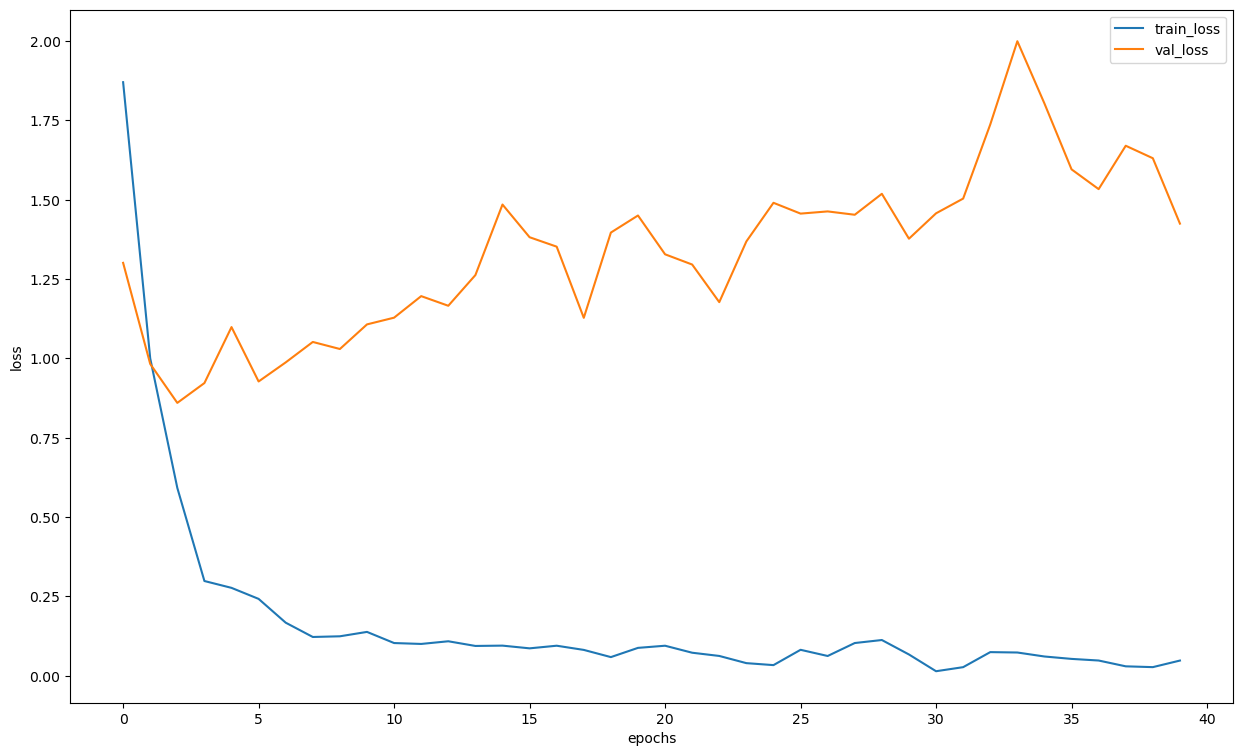

In [23]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

**По графику видно что train_loss падает, а val_loss остается примерно на одном значении**

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [30]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [31]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [32]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [33]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [34]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [35]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.9500000000000001


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

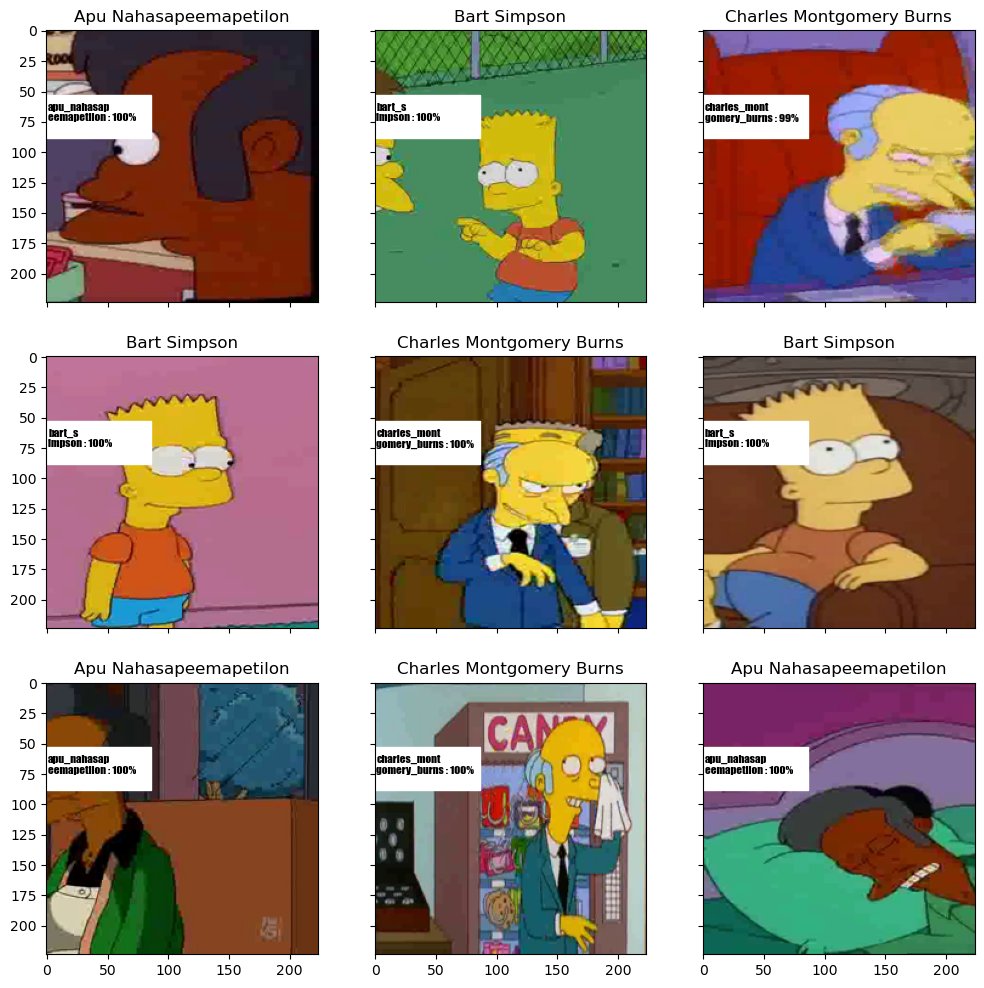

In [36]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [37]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [38]:
#! ls

In [39]:
import pandas as pd
my_submit = pd.read_csv("./sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [40]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [41]:
my_submit.Id = test_filenames
my_submit.Expected = preds

In [42]:
def extract_number(s):
    return int(''.join(filter(str.isdigit, s)))

In [43]:
submit_sorted = my_submit.iloc[my_submit['Id'].str.extract(r'img(\d+).jpg', expand=False).astype(int).argsort()]

In [44]:
submit_sorted.to_csv('new_like_vgg_vers2_40_epochs.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
